In [ ]:
from google.colab import files

# Upload the Excel file (e.g., Data.xlsx)
uploaded = files.upload()


Saving Data.xlsx to Data.xlsx


In [ ]:
import pandas as pd

# Load the Excel file (replace filename if different)
xls = pd.ExcelFile("Data.xlsx")

# Preview sheet names
print("Available sheets:", xls.sheet_names)

# Load the main 'PROJECTS' sheet in the Berkeley dataset and skip header rows
df = xls.parse("PROJECTS", skiprows=3)

# Clean column names
df.columns = [str(col).strip() for col in df.columns]
df = df.loc[:, ~df.columns.str.contains("^Unnamed|nan", case=False)]

# Show shape and first few rows
print("Data shape:", df.shape)
df.head()


Available sheets: ['PROJECTS']
Data shape: (10148, 167)


,Project ID,Project Name,Voluntary Registry,ARB / WA \nProject,Voluntary Status,Scope,Type,Reduction / Removal,Methodology / Protocol,Methodology Version,...,2021.3,2022.3,2023.3,2024.3,2025.3,Project Description,Notes from Registry,Notes from Berkeley Carbon Trading Project,Date Project Added to Database,"1st issuance yr (no hard code, hide)"
0,ACR102,Air Bag Gas Substitution,ACR,No,Completed,Chemical Processes,SF6 Replacement,Reduction,Emission reductions through industrial gas sub...,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2020-12-08,0.0
1,ACR103,Inland Empire Anaerobic Ag Digester,ACR,No,Completed,Agriculture,Manure Methane Digester,Reduction,"Monitoring, Reporting, and Verification Protoc...",NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2020-12-08,0.0
2,ACR105,Boa Vista A/R,ACR,No,Canceled,Forestry & Land Use,Afforestation/Reforestation,Impermanent Removal,AR-ACM0001 Afforestation and reforestation of ...,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2020-12-08,0.0
3,ACR106,Brickyard LFG to Energy,ACR,No,Completed,Waste Management,Landfill Methane,Reduction,"Monitoring, Reporting and Verification Protoco...",NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2020-12-08,0.0
4,ACR107,Camargo Fuel Substitution,ACR,No,Completed,Industrial & Commercial,Fuel Switching,Reduction,ACM0011 Fuel switching from coal and/or petrol...,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2020-12-08,0.0


In [ ]:
# Drop rows with no Project ID
df = df[df['Project ID'].notna()]

# Check for nulls
null_counts = df.isnull().sum().sort_values(ascending=False)

# Summary of key columns
summary = df[['Project ID', 'Project Name', 'Voluntary Registry', 'Scope', 'Type', 'Country']].describe(include='all')

null_counts.head(10)


,0
Notes from Registry,10051
Notes from Berkeley Carbon Trading Project,10033
Authorized Project Designee,10031
Sustainability Certifications,9829
Project Website,9631
ARB / WA ID,9458
Offset Project Operator,9388
Project Listed,9098
Project Owner,9093
Methodology Version,8765


In [ ]:
df['Voluntary Registry'].value_counts()


,count
Voluntary Registry,
VCS,4551
GOLD,3692
CAR,1052
ACR,850


In [ ]:

# Step 1: Identify credit issuance columns (e.g., '2002.3', '2023.3')
issuance_cols = [col for col in df.columns if col.endswith('.3') and col.replace('.3', '').isdigit()]

# Step 2: Create new features based on issuance behavior
df['total_credits_issued'] = df[issuance_cols].sum(axis=1)
df['issuance_years'] = df[issuance_cols].gt(0).sum(axis=1)
df['avg_credits_per_year'] = df['total_credits_issued'] / df['issuance_years'].replace(0, 1)

# Find first and last year with non-zero issuance
df['first_issuance_year'] = df[issuance_cols].gt(0).idxmax(axis=1).str.extract(r'(\d+)\.3').astype(float)
df['last_issuance_year'] = df[issuance_cols].gt(0).iloc[:, ::-1].idxmax(axis=1).str.extract(r'(\d+)\.3').astype(float)
df['issuance_span'] = df['last_issuance_year'] - df['first_issuance_year'] + 1
df['issuance_span'] = df['issuance_span'].fillna(0).clip(lower=0)

# Step 3: Preview engineered features
df[['Project ID', 'total_credits_issued', 'issuance_years', 'avg_credits_per_year', 'issuance_span']].head()



,Project ID,total_credits_issued,issuance_years,avg_credits_per_year,issuance_span
0,ACR102,7984006.0,2,3992003.0,2.0
1,ACR103,44202.0,4,11050.5,6.0
2,ACR105,2572210.0,1,2572210.0,1.0
3,ACR106,138492.0,1,138492.0,1.0
4,ACR107,1138.0,1,1138.0,1.0


In [ ]:
df.groupby('Country')['total_credits_issued'].sum().sort_values(ascending=False).head(10)


,total_credits_issued
Country,
United States,511532228.0
India,379300024.0
China,248902844.0
Brazil,135651645.0
Türkiye,129952890.0
Indonesia,97003160.0
Peru,96452501.0
Kenya,72330956.0
Cambodia,53239466.0


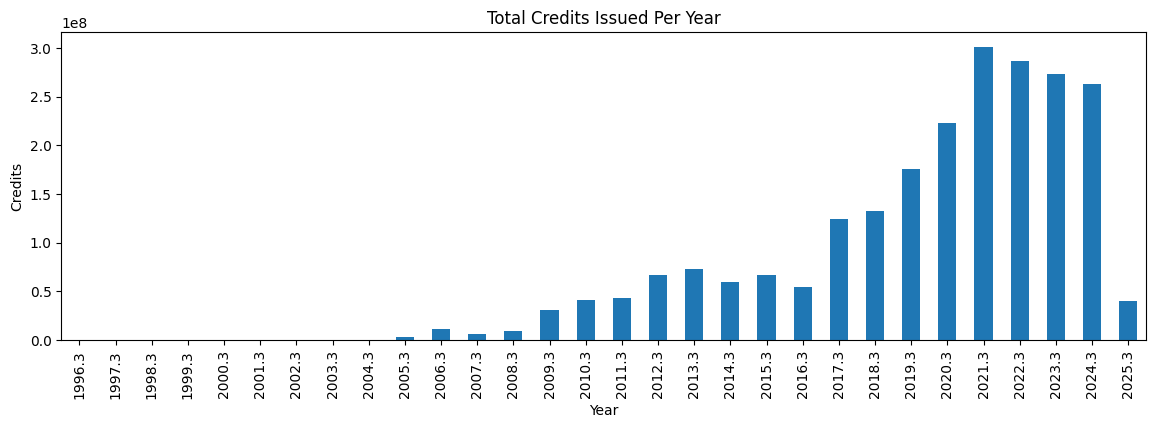

In [ ]:
import matplotlib.pyplot as plt

# Total credits issued each year
issuance_cols = [col for col in df.columns if col.endswith('.3') and col.replace('.3', '').isdigit()]
df[issuance_cols].sum().sort_index().plot(kind='bar', figsize=(14, 4))
plt.title('Total Credits Issued Per Year')
plt.ylabel('Credits')
plt.xlabel('Year')
plt.show()


"Total credits issued" = the total number of carbon offset credits that a project has been awarded over its lifetime.
Each credit = 1 ton of CO₂ (or equivalent) that the project is supposed to have prevented from being emitted.

In [ ]:
# Clean column names and drop unnamed
df.columns = [str(col).strip() for col in df.columns]
df = df.loc[:, ~df.columns.str.contains("^Unnamed|nan", case=False)]

# Columns to inspect
categorical_cols = ['Voluntary Registry', 'Voluntary Status', 'Scope', 'Type', 'Country', 'Project Developer']

# Print unique values for each
for col in categorical_cols:
    print(f"\n🔹 {col} ({df[col].nunique()} unique values):")
    print(df[col].dropna().unique())



🔹 Voluntary Registry (4 unique values):
['ACR' 'CAR' 'GOLD' 'VCS']

🔹 Voluntary Status (26 unique values):
['Completed' 'Canceled' 'Registered' 'Listed' 'Inactive' 'Transitioned'
 'Gold Standard Certified Project' 'Gold Standard Certified Design'
 'Late to verify' 'Withdrawn' 'Verification approval requested'
 'Crediting Period Renewal Request Denied'
 'Verification approval request denied'
 'Crediting Period Renewal Requested'
 'Crediting Period Renewal and Verification Approval Requested'
 'Crediting Period Renewal and Verification Approval Request Denied'
 'On Hold - see notification letter' 'Under validation'
 'Under development' 'Registration request denied'
 'Rejected by Administrator' 'Registration requested'
 'Registration and verification approval requested'
 'Units Transferred from Approved GHG Program'
 'Registration and verification approval request denied'
 'Transfer to Another GHG Program']

🔹 Scope (9 unique values):
['Chemical Processes' 'Agriculture' 'Forestry & Land 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest

# Step 1: Select features for modeling
features = df[['total_credits_issued', 'issuance_years', 'avg_credits_per_year', 'issuance_span']]

# Step 2: Impute missing values (if any)
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

# Step 3: Standardize features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Step 4: Fit Isolation Forest
model = IsolationForest(contamination=0.05, random_state=42)
df['anomaly_flag'] = model.fit_predict(features_scaled)  # -1 = anomaly, 1 = normal
df['anomaly_score'] = model.decision_function(features_scaled)

# Step 5: View top anomalies
anomalies = df[df['anomaly_flag'] == -1].sort_values(by='anomaly_score')
anomalies[['Project ID', 'Project Name', 'total_credits_issued', 'issuance_years', 'avg_credits_per_year', 'issuance_span', 'anomaly_score']].head()


,Project ID,Project Name,total_credits_issued,issuance_years,avg_credits_per_year,issuance_span,anomaly_score
6516,VCS934,The Mai Ndombe REDD+ Project,39929804.0,4,9.982451e+06,13.0,-0.231116
5682,VCS92,300MW Hydropower project by JHPL,19058923.0,8,2.382365e+06,15.0,-0.231116
6567,VCS985,Cordillera Azul National Park REDD Project,36612042.0,4,9.153010e+06,10.0,-0.230564
7051,VCS1477,Katingan Peatland Restoration and Conservation...,39998290.0,5,7.999658e+06,6.0,-0.226161
6258,VCS674,Rimba Raya Biodiversity Reserve Project,33625616.0,6,5.604269e+06,9.0,-0.225145


In [ ]:
# Step 1: Filter top 10 anomalies
top_anomalies = df[df['anomaly_flag'] == -1].sort_values(by='anomaly_score').head(10)

# Step 2: Optional – filter anomalies from Verra (VCS) registry only
verra_anomalies = df[(df['Voluntary Registry'] == 'VCS') & (df['anomaly_flag'] == -1)]

# Step 3: View the filtered anomalies
verra_anomalies[['Project ID', 'Project Name', 'Country', 'total_credits_issued',
                 'issuance_years', 'avg_credits_per_year', 'issuance_span', 'anomaly_score']].head()


,Project ID,Project Name,Country,total_credits_issued,issuance_years,avg_credits_per_year,issuance_span,anomaly_score
5598,VCS5,Greater Lebanon Refuse Authority Landfill Gas ...,United States,302561.0,12,2.521342e+04,16.0,-0.071699
5603,VCS10,BAESA Project,Brazil,6726799.0,3,2.242266e+06,13.0,-0.182373
5605,VCS12,Chuanwei Group 24 MW Waste Gas based Captive P...,China,1162620.0,2,5.813100e+05,13.0,-0.045734
5606,VCS13,Coal Mine Methane Capture and Use Project at t...,United States,1517455.0,2,7.587275e+05,8.0,-0.047248
5622,VCS30,Hunan Dongping 72MW Hydropower Project,China,1106847.0,3,3.689490e+05,15.0,-0.047993


In [ ]:
# Save all anomalies to a CSV file
df[df['anomaly_flag'] == -1][[
    'Project ID', 'Project Name', 'Country', 'Voluntary Registry',
    'total_credits_issued', 'issuance_years', 'avg_credits_per_year',
    'issuance_span', 'anomaly_score'
]].to_csv("flagged_anomalies_structured.csv", index=False)


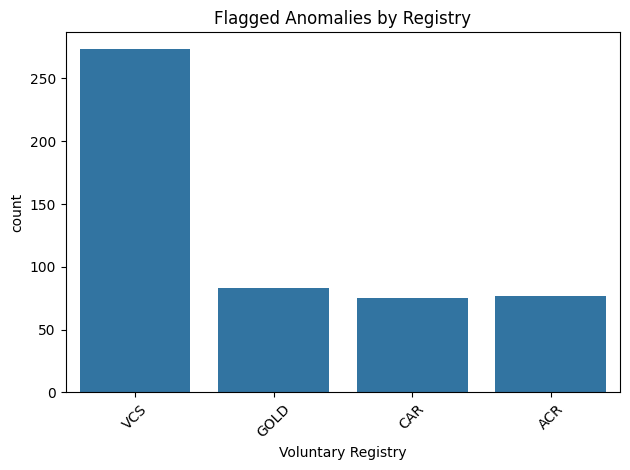

In [ ]:
import seaborn as sns

sns.countplot(data=df[df['anomaly_flag'] == -1], x='Voluntary Registry', order=df['Voluntary Registry'].value_counts().index)
plt.title('Flagged Anomalies by Registry')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
